#  Chemical Langevin equation

$$
X_i(t+\tau) = X_i(t) + \sum_{j=1}^M \nu_{ji} \left[ a_j(x_t)\tau + \left( a_j(x_t)\tau \right)^{1/2} \mathcal{N}(0,1) \right]
$$

In [1]:
import sys
sys.path.append("../..")

In [2]:
# Numpy is used to set the timespan of the Model.
import numpy

# Import the types that'll be needed to define your Model.
from gillespy2.core import (
    Model,
    Species,
    Reaction,
    Parameter
)

In [3]:
from gillespy2 import SSACSolver
from gillespy2 import ODECSolver
from gillespy2 import CLESolver
from matplotlib import pyplot as plt

In [4]:
class MichaelisMenten(Model):
     def __init__(self, scaling=1):

            # Intialize the Model with a name of your choosing.
            Model.__init__(self, name="Michaelis_Menten")
            
            """
            Parameters are constant values relevant to the system, such as reaction kinetic rates.
            
            - name: A user defined name for reference.
            - expression: Some constant value.
            """

            rate1 = Parameter(name="rate1", expression=0.0017)
            rate2 = Parameter(name="rate2", expression=0.5)
            rate3 = Parameter(name="rate3", expression=0.1)
            
            # Add the Parameters to the Model.
            self.add_parameter([rate1, rate2, rate3])
            
            """
            Species can be anything that participates in or is produced by a reaction channel.
            
            - name: A user defined name for the species.
            - initial_value: A value/population count of species at start of simulation.
            """

            A = Species(name="A", initial_value=301*scaling)
            B = Species(name="B", initial_value=120*scaling)
            C = Species(name="C", initial_value=0)
            D = Species(name="D", initial_value=0)
            
            # Add the Species to the Model.
            self.add_species([A, B, C, D])
            
            """
            Reactions are the reaction channels which cause the system to change over time.
            
            - name: A user defined name for the reaction.
            - reactants: A dictionary with participant reactants as keys, and consumed per reaction as value.
            - products: A dictionary with reaction products as keys, and number formed per reaction as value.
            - rate: A parameter rate constant to be applied to the propensity of this reaction firing.
            - propensity_function: Can be used instead of rate in order to declare a custom propensity function in string format.
            """

            r1 = Reaction(
                    name="r1",
                    reactants={A: 1, B: 1}, 
                    products={C: 1},
                    rate=rate1
                )
            
            r2 = Reaction(
                    name="r2",
                    reactants={C: 1}, 
                    products={A: 1, B: 1},
                    rate=rate2
                )
            
            r3 = Reaction(
                    name="r3",
                    reactants={C: 1}, 
                    products={B: 1, D: 1},
                    rate=rate3
                )
            
            # Add the Reactions to the Model.
            self.add_reaction([r1, r2, r3])
            
            # Use NumPy to set the timespan of the Model.
            self.timespan(numpy.linspace(0, 100, 101))

In [5]:
model = MichaelisMenten()

In [6]:
%time result = model.run(solver=SSACSolver)

CPU times: user 4.11 ms, sys: 8.2 ms, total: 12.3 ms
Wall time: 3.36 s


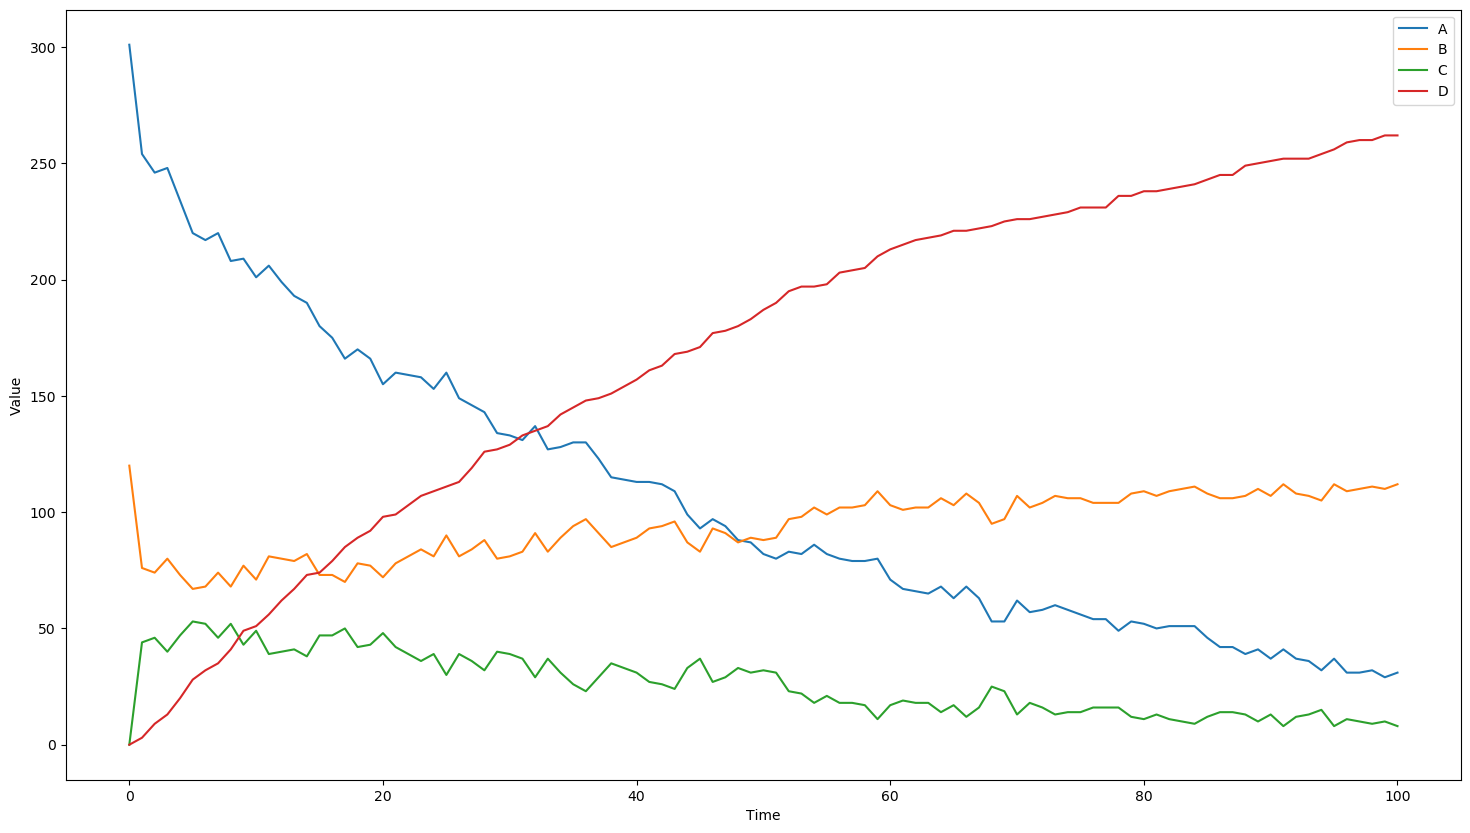

In [7]:
result.plot()

In [8]:
model2 = MichaelisMenten(2)

In [9]:
%time result2 = model2.run(solver=SSACSolver)

CPU times: user 0 ns, sys: 11.4 ms, total: 11.4 ms
Wall time: 2.69 s


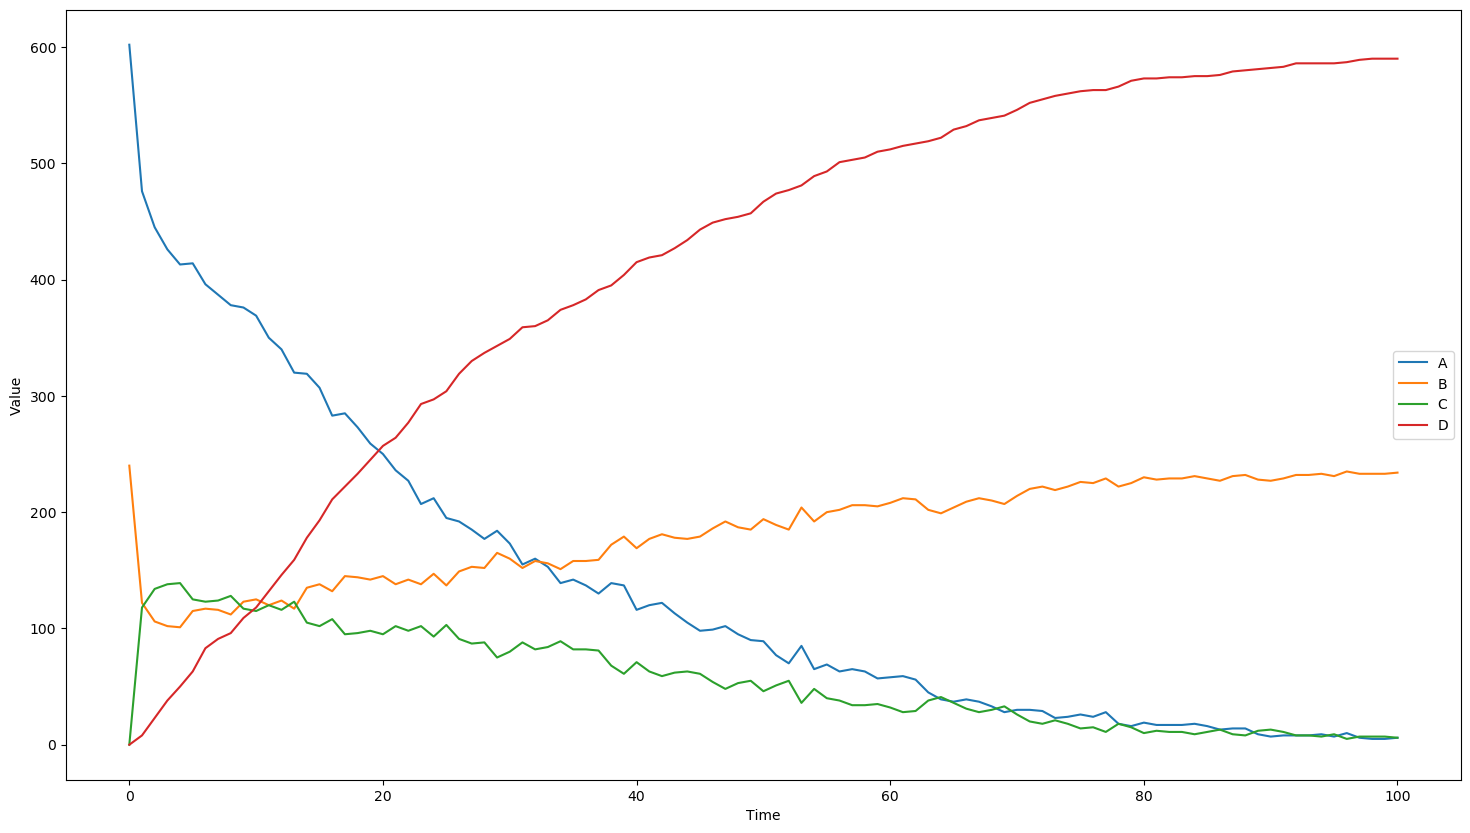

In [10]:
result2.plot()

CPU times: user 12.4 ms, sys: 825 µs, total: 13.2 ms
Wall time: 2.69 s


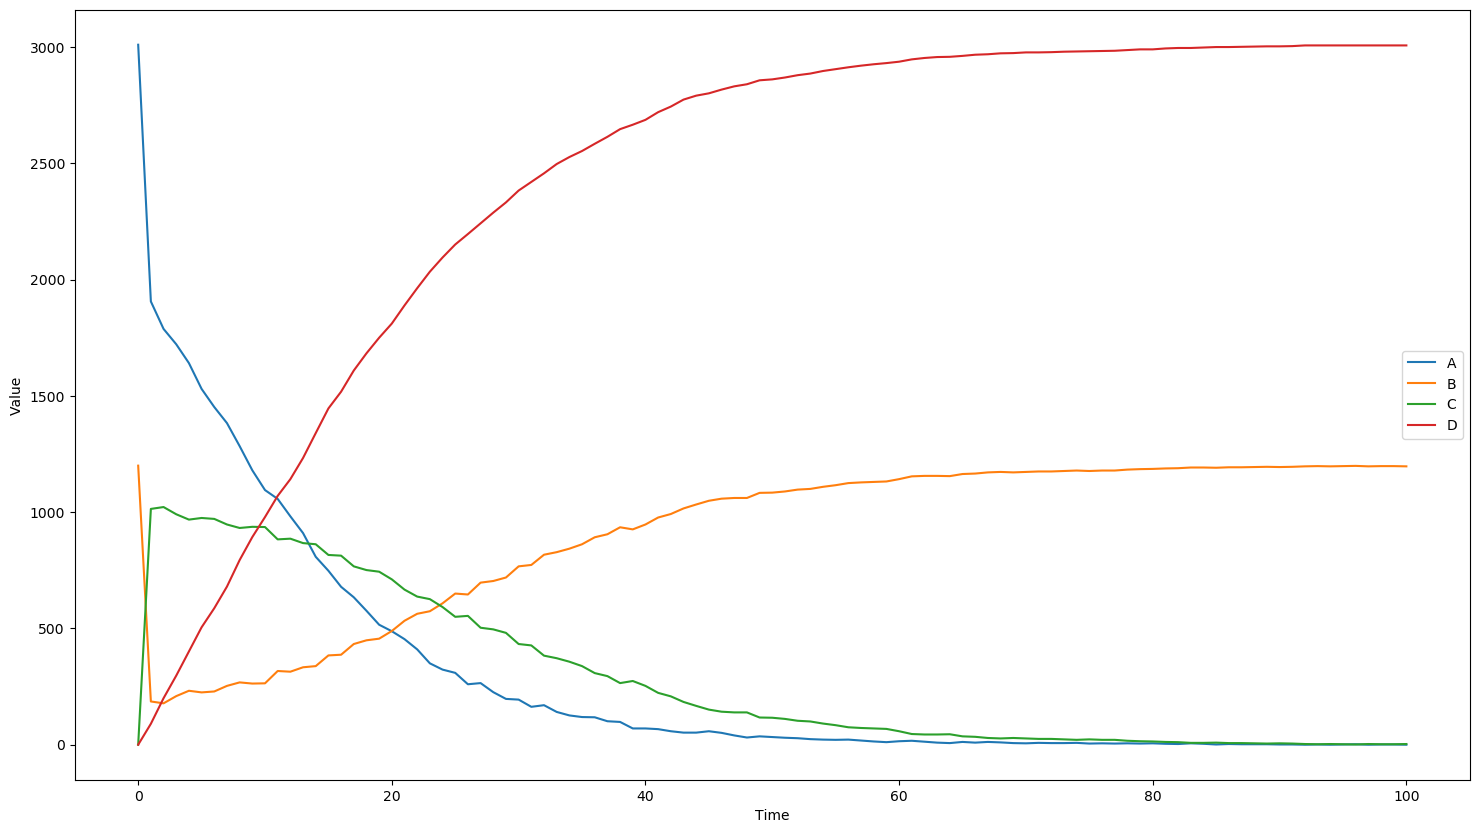

In [11]:
model10 = MichaelisMenten(10)
%time result10 = model10.run(solver=SSACSolver)
result10.plot()

CPU times: user 2.65 ms, sys: 11.7 ms, total: 14.4 ms
Wall time: 2.77 s


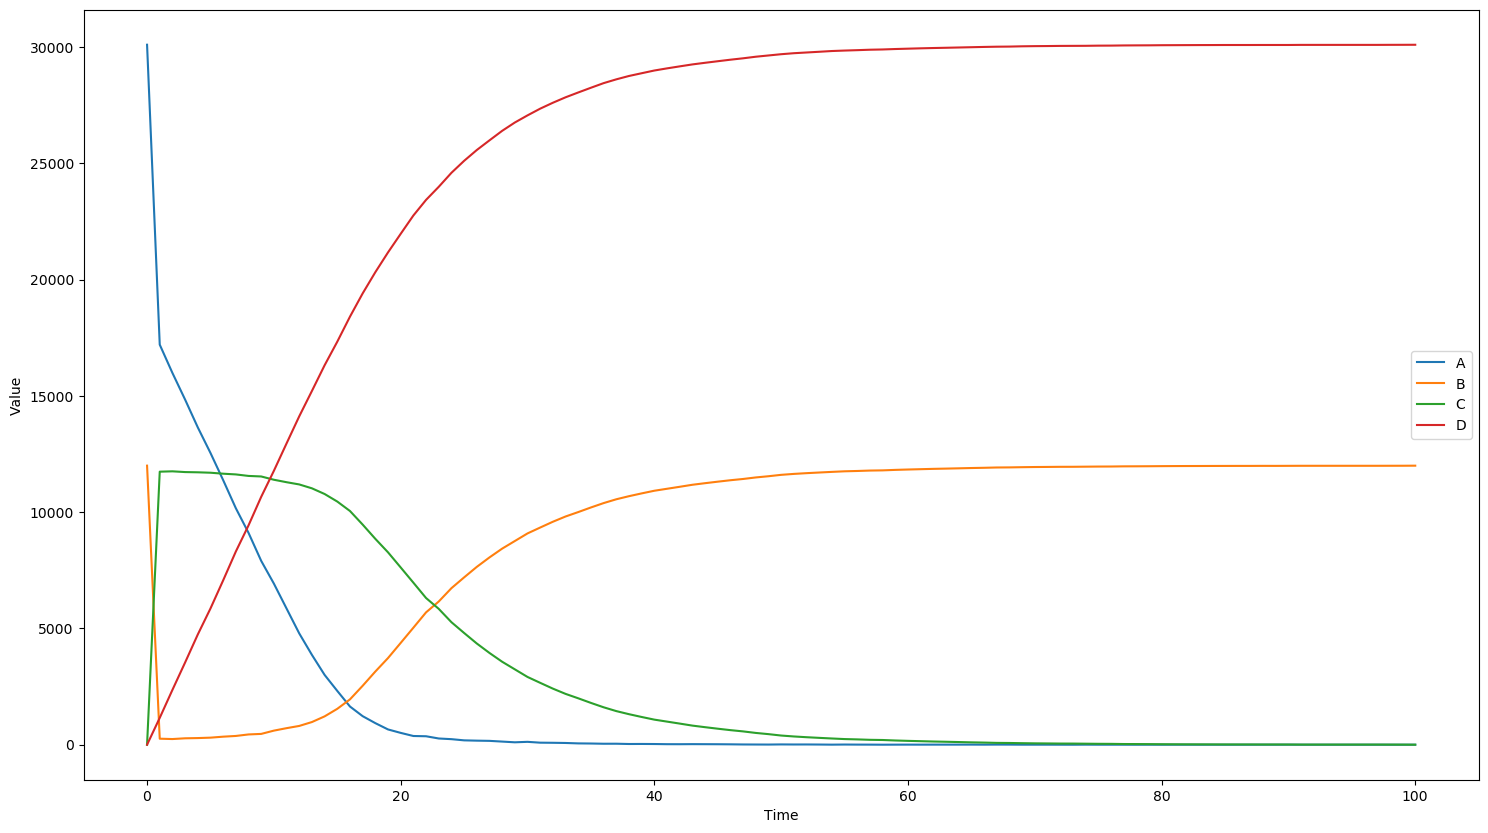

In [12]:
model100 = MichaelisMenten(100)
%time result100 = model100.run(solver=SSACSolver)
result100.plot()

CPU times: user 44 µs, sys: 15.8 ms, total: 15.9 ms
Wall time: 6.07 s


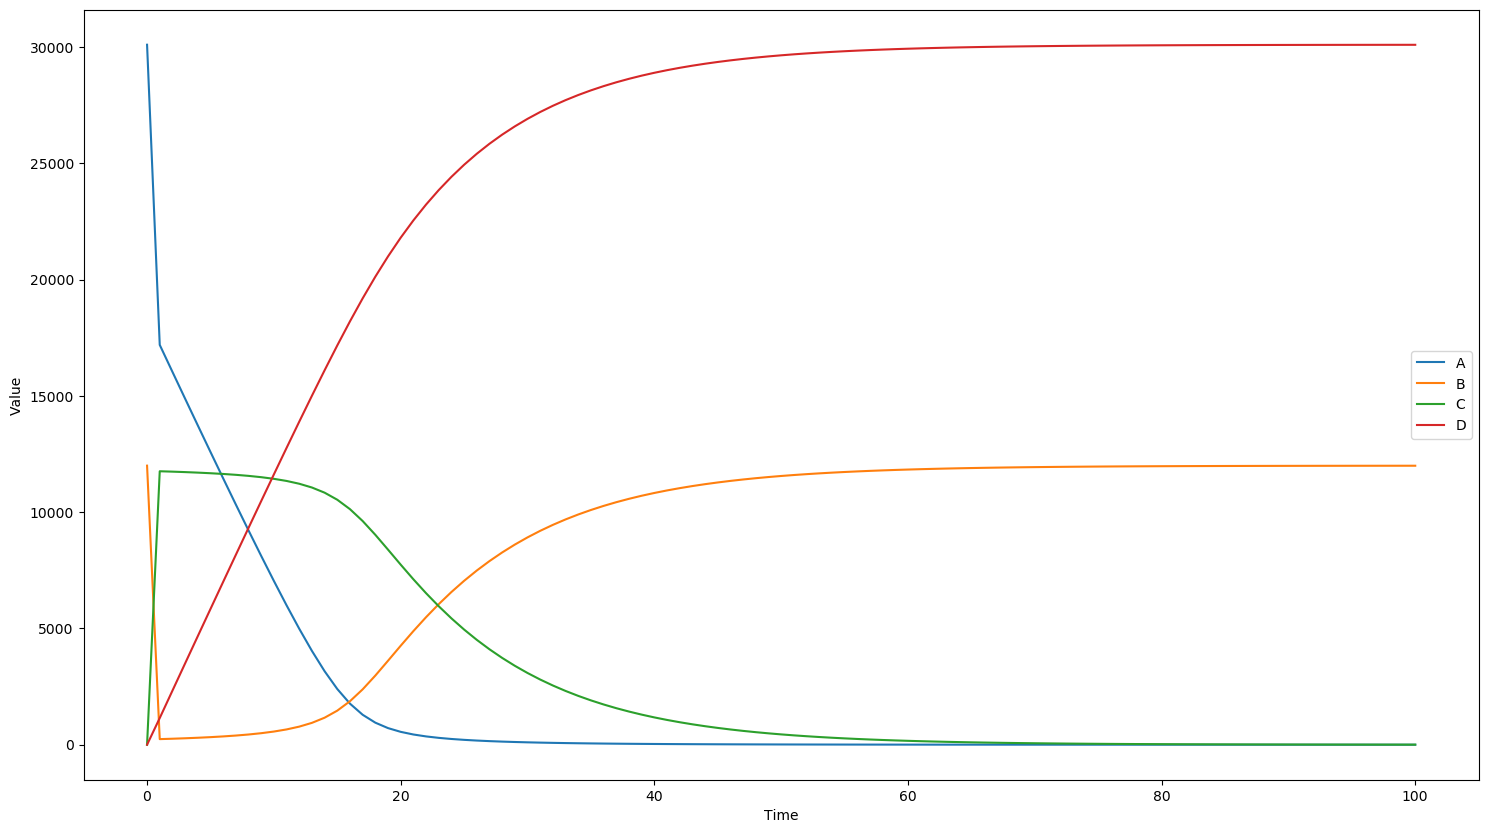

In [13]:
%time dresult100 = model100.run(solver=ODECSolver)
dresult100.plot()

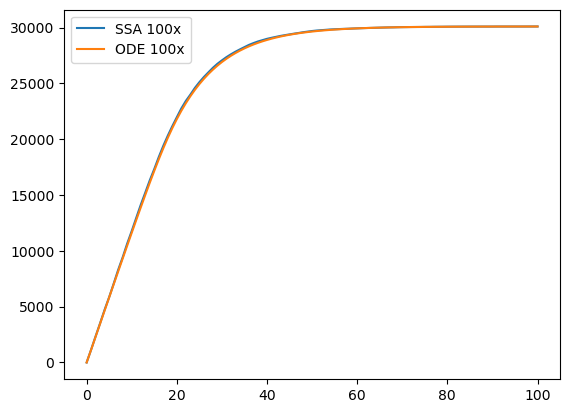

In [14]:
plt.plot(result100['time'],result100['D'],label='SSA 100x')
plt.plot(dresult100['time'],dresult100['D'],label='ODE 100x')
plt.legend(loc='best')

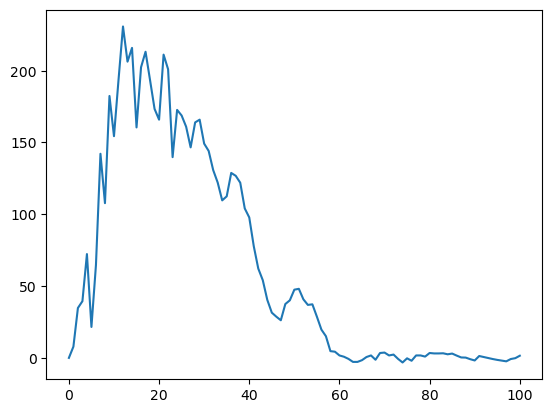

In [15]:
plt.plot(result100['time'],(result100['D']-dresult100['D']))

In [16]:
abs(numpy.max((result100['D']-dresult100['D'])))

230.79999999999927

In [17]:
n=5
m = MichaelisMenten(n)
s = m.run(solver=SSACSolver)
c = m.run(solver=CLESolver)
o = m.run(solver=ODECSolver)


In [18]:
sc= abs(numpy.max((s['D']-c['D'])))
so= abs(numpy.max((s['D']-o['D'])))
co= abs(numpy.max((c['D']-o['D'])))


In [19]:
import scipy

In [20]:
sc= scipy.linalg.norm(s['D']/n - c['D']/n)
so= scipy.linalg.norm(s['D']/n - o['D']/n)
co= scipy.linalg.norm(c['D']/n - o['D']/n)


In [21]:
def ode_cle_ssa_distance(n):
    m = MichaelisMenten(n)
    s = m.run(solver=SSACSolver)
    c = m.run(solver=CLESolver)
    o = m.run(solver=ODECSolver)
    #sc= abs(numpy.max((s['D']-c['D'])))
    #so= abs(numpy.max((s['D']-o['D'])))
    #co= abs(numpy.max((c['D']-o['D'])))
    sc= scipy.linalg.norm(s['D']/n - c['D']/n)
    so= scipy.linalg.norm(s['D']/n - o['D']/n)
    co= scipy.linalg.norm(c['D']/n - o['D']/n)
    return {'sc':sc,'so':so,'co':co,'s':s,'c':c,'o':o}

def plot_d(d):
    for l in ['sc','so','co']:
        print(f"{l}: {d[l]}")
    for l in ['s','c','o']:
        plt.plot(d[l]['time'],d[l]['D'], label=l)
    plt.legend(loc='best')


In [22]:
%time d = ode_cle_ssa_distance(100)

CPU times: user 1.94 s, sys: 11.6 ms, total: 1.95 s
Wall time: 10.2 s


sc: 61.82490449122823
so: 2.9933888972200093
co: 59.590402934954085


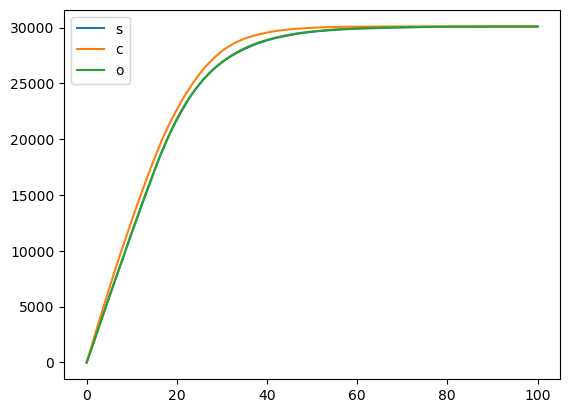

In [23]:
plot_d(d)

CPU times: user 3min 5s, sys: 73.9 ms, total: 3min 5s
Wall time: 3min 16s
sc: 55.51403868811225
so: 0.5063234045548471
co: 55.07034713777287


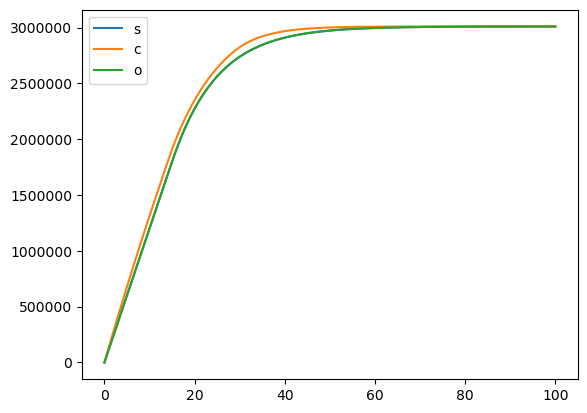

In [24]:
%time d5 = ode_cle_ssa_distance(10000)
plot_d(d5)

In [25]:
nlist=[10,50,100,500,1000,5000,10000]
def convergence_study():  
    global nlist
    clist = []
    for n in nlist:
        print(f"n={n}")
        clist.append(ode_cle_ssa_distance(n))
    return clist

In [26]:
%time clist = convergence_study()

n=10
n=50
n=100
n=500
n=1000
n=5000
n=10000
CPU times: user 5min 12s, sys: 140 ms, total: 5min 13s
Wall time: 6min 15s


sc=[87.91377340737743, 56.75493145719586, 57.70935318341972, 57.19416261373707, 56.67931897803168, 54.3434539777405, 54.830507483521906]
so=[17.254058397559675, 14.394357632364152, 2.7690007385336783, 2.2425236520491754, 1.3910129869990382, 1.6200960022171578, 0.2059785425717838]
co=[77.72818386501045, 69.95262520828699, 59.460548427830574, 59.049732123015936, 55.80894220769433, 55.79303943598805, 54.75422182896891]


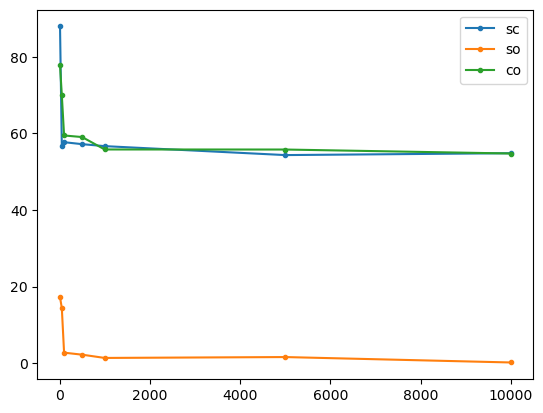

In [27]:
sc=[]
so=[]
co=[]
for c in clist:
    sc.append(c['sc'])
    so.append(c['so'])
    co.append(c['co'])
plt.plot(nlist,sc,'.-',label='sc')
print(f"sc={sc}")
plt.plot(nlist,so,'.-',label='so')
print(f"so={so}")
plt.plot(nlist,co,'.-',label='co')
print(f"co={co}")
plt.legend(loc='best')